<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Fit-Linear-Models" data-toc-modified-id="Fit-Linear-Models-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Fit Linear Models</a></span></li></ul></div>

# Performance Profiling of Validation Simulations

In [188]:
import pandas as pd
from typing import Any
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np

In [9]:
from pathlib import Path
import os

In [3]:
gpu_profile_dir = Path("../profiles")

In [4]:
line_profile_dir = Path("../profiling")

In [5]:
line_profile_dir.exists()

True

In [6]:
import sys

In [7]:
sys.path.append("..")

In [10]:
os.environ['VALIDATION_SYSTEM_NAME'] = "NRAO"

In [13]:
from core.utils import ANTS_DICT

In [28]:
def parse_profiling_fname(fname: str) -> dict[str, Any]:
    if not fname.endswith("profile.txt"):
        raise ValueError(f"fname {fname} doesn't end with .profile.txt")
    
    parts = fname.replace(".profile.txt", "").split("-")
    sky, gpu, nt, layout, mv, hs = parts
    nside = int(sky[5:])  # only works for ptsrc!!
    gpu = 'True' in gpu
    ntimes = 17280 // int(nt[2:])
    nant = len(ANTS_DICT[layout])
    
    return {
        'nside': nside,
        'gpu': gpu,
        'ntimes': ntimes,
        'nant': nant,
        'layout': layout,
        'matvis version': mv[2:],
        'hera_sim version': hs[2:],
        'sky': sky
    }
    

In [137]:
def parse_timing_line(line: str):
    parts = line.split()
    line_number, nhits, t, t_per_hit, percent = parts[:5]
    contents = parts[5] + line.split(parts[5])[-1]
    #print(line, parts[:5], contents)
    return int(line_number), int(nhits), float(t), float(t_per_hit), float(percent), contents

def get_lineprof(fname):
    """We don't trust any of the line profiling times for GPU code calls, because they're not synced.
    
    To get timings for each step, we need the GPU profiling tools.
    """
    with open(fname, 'r') as fl:
        lines = fl.readlines()
        
    total_times = []
    sim_time = 0
    setup_time = 0
    writeout_time = 0
    sim_nonloop_time = 0
    sim_loop_time = 0
    
    in_run_vis_sim = False
    in_simulate = False
    before_simulate = True
    in_time_loop = False
    for line in lines:
        
        if "Total time:" in line:
            # Each function has a total time -- we get the longest one as probably the 'outer' one
            thist = float(line.split(":")[-1].split(" s")[0])
            total_times.append(thist)
            
                    
        if "def run_vis_sim" in line:
            in_run_vis_sim = True
        if "def simulate" in line:
            in_simulate = True
            
        if line.startswith("======================="):
            in_run_vis_sim = False
            in_simulate = False
        
        try:
            # if the line doesn't parse, just ignore it, it's not a code line
            _, _, t, _, _, contents = parse_timing_line(line)
        except Exception as e:
            #print(e)
            continue

        if "simulation.simulate()" in contents:
            before_simulate = False
            sim_time = t
        elif in_run_vis_sim and not before_simulate:
            writeout_time += t
            
        if before_simulate and in_run_vis_sim:
            setup_time += t
            
        if "for t in range(ntimes):" in contents:
            in_time_loop = True
        if "cublasDestroy(h)" in contents:
            in_time_loop = False
        
        if in_simulate and not in_time_loop:
            sim_nonloop_time += t
        if in_simulate and in_time_loop:
            sim_loop_time += t
            
    return {
        'total_time': max(total_times),
        'sim_time': min(total_times),
        'setup_time': setup_time*1e-9,
        'write_time':writeout_time*1e-9,
        'nonloop_time': sim_nonloop_time*1e-9,
        'loop_time': sim_loop_time*1e-9,
    }

In [120]:
def get_gpufile(fl: Path):
    return gpu_profile_dir / fl.stem.replace('.profile', '_gpukernsum.csv')

def get_gpu_times(fl: Path):
    return pd.read_csv(get_gpufile(fl))

def get_time(df, label) -> float:
    return float(df[df['Name'].str.contains(label)]['Total Time (ns)']) * 1e-9

def get_gpu_summaries(fl: Path):
    d = get_gpu_times(fl)
    return {
        'matmul': get_time(d, 'zgemm'),
        'getz': get_time(d, 'MeasEq'),
        'coords': get_time(d, 'dgemm'),
        'beam': get_time(d, 'InterpolateBeamAltAz'),
    }

In [172]:
def get_gpu_api_file(fl: Path):
    return gpu_profile_dir / fl.stem.replace('.profile', '_cudaapisum.csv')

def get_gpu_api_times(fl: Path):
    return pd.read_csv(get_gpu_api_file(fl))

def get_gpu_api_summaries(fl: Path, nt: int):
    d = get_gpu_api_times(fl)
    return {
        'gpu_api': d[d['Num Calls'] >= nt]['Total Time (ns)'].sum() * 1e-9
    }

In [173]:
all_files = sorted(line_profile_dir.glob("*.profile.txt"))

all_params = []
for fl in all_files:
    params = parse_profiling_fname(fl.name)
    if params['hera_sim version'] != "4.2.1.dev7+g16673cb":
        continue
    timings = get_lineprof(fl)
    gpu_timings = get_gpu_summaries(fl)
    gpu_api_timings = get_gpu_api_summaries(fl, params['ntimes'])
    all_params.append({**params, **timings, **gpu_timings, **gpu_api_timings})
    

In [174]:
sim_table = pd.DataFrame(all_params)

In [175]:
sim_table['nsources'] = 12*sim_table['nside']**2

In [234]:
# Probable H6C parameters

nant_norm = 350
ntime_norm = 720
nside_norm = 512

In [261]:
sim_table['nant_norm'] = sim_table['nant']/nant_norm
sim_table['ntimes_norm'] = sim_table['ntimes']/ntime_norm
sim_table['nsources_norm'] = sim_table['nsources']/(12 * nside_norm**2)

# Different things we could scale with
sim_table['bls'] = sim_table['nant']**2
sim_table['bls_norm'] = sim_table['nant_norm']**2

sim_table['blts'] = sim_table['bls']*sim_table['ntimes']
sim_table['blts_norm'] = sim_table['bls_norm'] * sim_table['ntimes_norm']
sim_table['ant_times'] = sim_table['nant'] * sim_table['ntimes']
sim_table['ant_times_norm'] = sim_table['nant_norm'] * sim_table['ntimes_norm']

sim_table['blts x nsource'] = sim_table['blts'] * sim_table['nsources']
sim_table['blts x nsource norm'] = sim_table['blts_norm'] * sim_table['nsources_norm']

sim_table['nant x ntime x nsource'] = sim_table['ant_times'] * sim_table['nsources']
sim_table['nant x ntime x nsource norm'] = sim_table['ant_times_norm'] * sim_table['nsources_norm']

sim_table['ntime x nsource'] = sim_table['ntimes'] * sim_table['nsources']
sim_table['ntime x nsource norm'] = sim_table['ntimes_norm'] * sim_table['nsources_norm']

In [236]:
sim_table[['nside', 'ntimes', 'nant', 'total_time', 'sim_time', 'loop_time', 'nonloop_time', 'gpu_api', 'matmul', 'getz', 'beam', 'write_time', 'setup_time']]

,nside,ntimes,nant,total_time,sim_time,loop_time,nonloop_time,gpu_api,matmul,getz,beam,write_time,setup_time
0,128,720,350,356.484,116.6300,116.556977,3.730459,97.906982,78.756139,6.290681,0.037884,2.123941,203.202899
1,128,720,126,370.428,118.5810,119.073453,3.683452,22.393531,10.916657,2.341869,0.035517,2.215819,203.239405
2,128,720,320,298.646,98.8676,96.724380,3.193637,81.053864,62.045447,5.878275,0.036853,1.846509,102.652983
3,128,480,350,232.301,80.0315,79.137094,2.608578,66.817889,53.198737,4.265945,0.025689,1.522770,102.161899
4,128,480,126,243.352,83.9122,82.085435,2.697273,14.838830,7.038649,1.531093,0.023604,2.186177,102.219567
5,128,480,320,193.072,66.8036,68.287639,2.324527,53.972335,41.656136,3.911955,0.024733,1.737091,81.890581
6,256,720,350,671.948,422.3570,375.659646,3.659366,376.337323,308.993234,27.076605,0.131318,2.212610,203.113589
7,256,720,126,575.717,366.1390,383.941201,3.283938,75.911131,39.097884,9.769306,0.125255,1.948073,102.713149
8,256,720,320,561.021,358.5410,369.685855,3.207099,313.823100,254.111751,24.752901,0.128517,1.913272,102.649344
9,256,480,350,438.570,284.6840,256.178978,2.643669,253.625968,210.904895,18.021353,0.088000,1.799297,102.183056


## Fit Linear Models

In [244]:
def get_fit(x, y, only_large=True):
    if only_large:
        sims = sim_table[sim_table['nant']>300]
    else:
        sims = sim_table
    regr = linear_model.LinearRegression()
    regr.fit(np.array(sims[x]).reshape(-1, 1), np.array(sims[y]).reshape(-1, 1))
    return regr

In [262]:
setup_scaling = get_fit('blts_norm', 'setup_time')
write_scaling = get_fit("blts_norm", 'write_time')
nonloop_scaling = get_fit("ant_times_norm", 'nonloop_time')

matmul_scaling = get_fit("blts x nsource norm", 'matmul', only_large=False)
getz_scaling = get_fit("nant x ntime x nsource norm", 'getz', only_large=False)
coord_scaling = get_fit("nant x ntime x nsource norm", 'coords', only_large=False)
amb_scaling = get_fit("ntime x nsource norm", 'amb_time')

loop_scaling = get_fit("blts x nsource norm", 'loop_time')


In [279]:
def plot_pred(x, y, scaling, ax):    
    sim_table.plot.scatter(x, y, ax=ax, c='nant', cmap='viridis', colorbar=False)
    pred = scaling.predict(np.array(sim_table[x]).reshape(-1, 1))
    ax.plot(sim_table[x], pred, color='k')
    return pred

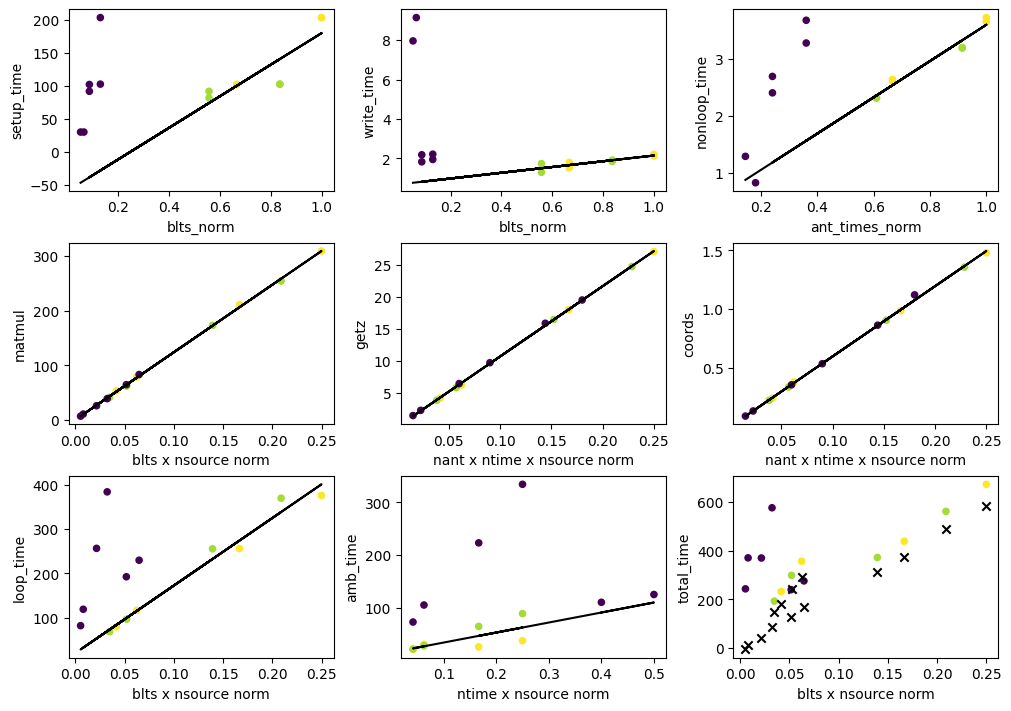

In [282]:
fig, ax = plt.subplots(3, 3, constrained_layout=True, figsize=(10, 7))

setup_pred = plot_pred('blts_norm', 'setup_time', setup_scaling, ax[0,0])
write_pred = plot_pred('blts_norm', 'write_time', write_scaling, ax[0,1])
nonloop_pred = plot_pred("ant_times_norm", 'nonloop_time', nonloop_scaling, ax[0,2])

matmul_pred = plot_pred('blts x nsource norm', 'matmul', matmul_scaling, ax[1,0])
getz_pred = plot_pred('nant x ntime x nsource norm', 'getz', getz_scaling, ax[1,1])
coord_pred = plot_pred('nant x ntime x nsource norm', 'coords', coord_scaling, ax[1,2])

loop_pred = plot_pred("blts x nsource norm", 'loop_time', loop_scaling, ax[2, 0])
amb_pred = plot_pred("ntime x nsource norm", 'amb_time', amb_scaling, ax[2, 1])

sim_table.plot.scatter('blts x nsource norm', 'total_time', ax=ax[2,2], c='nant', cmap='viridis', colorbar=False)
ax[2, 2].scatter(
    sim_table['blts x nsource norm'], 
    setup_pred + write_pred + matmul_pred + getz_pred + coord_pred + amb_pred, 
    color='k', marker='x'
)


This is obviously slightly under-predicted, and I'm not quite sure why. Furthermore, there seems to be a large discrepancy between small-$N_{\rm ant}$ and large-$N_{\rm ant}$ scalings, and I can't see why. Since we are more interested in large-$N_{\rm ant}$, I have based the predictions off these.

In [273]:
def time_calc(nant, nsource, unit='s', nchunks: int = 1, all_freqs: bool = False):
    ntimes = np.array([(17280/ntime_norm)]).reshape(-1, 1)
    nant = nant / nant_norm
    nsource = nsource / (12 * nside_norm**2)
    
    at = nant * ntimes
    ts = ntimes * nsource
    ats = at * nsource
    blt = at * nant
    bltsrc = blt * nsource
    time_sec = (
        setup_scaling.predict(blt) + write_scaling.predict(blt) + nonloop_scaling.predict(at) + 
        matmul_scaling.predict(bltsrc) + getz_scaling.predict(ats) + coord_scaling.predict(ats) + amb_scaling.predict(ts)
    )
    
    t = time_sec[0,0] / nchunks
    if all_freqs:
        t *= 1536
        
    if unit=='min':
        return t/60.0
    elif unit == 'hr':
        return t/3600.0
    else:
        return t

In [271]:
print("t_setup: ", setup_scaling.coef_[0,0])
print("t_write: ", write_scaling.coef_[0,0])
print("t_loop: ", loop_scaling.coef_[0,0])
print("t_nonloop: ", nonloop_scaling.coef_[0,0])
print("t_matmul: ", matmul_scaling.coef_[0,0])
print("t_z: ", getz_scaling.coef_[0,0] + coord_scaling.coef_[0,0])
print("t_amb: ", amb_scaling.coef_[0,0])


t_setup:  238.34916971371152
t_write:  1.4569077580234981
t_loop:  1523.3716419875489
t_nonloop:  3.1827132056817713
t_matmul:  1234.5782640056357
t_z:  115.49478879679114
t_amb:  189.7249850464866


In [276]:
print("Time required for single simulation for full HERA: ")
print(f"Per Task: {time_calc(350, 12*512**2, unit='min', all_freqs=False, nchunks=24):.1f} min")
print(f"Per Freq: {time_calc(350, 12*512**2, unit='hr', all_freqs=False):.1f} hr")
print(f"Per Sim: {time_calc(350, 12*512**2, unit='hr', all_freqs=True):.1f} hr")




Time required for single simulation for full HERA: 
Per Task: 29.7 min
Per Freq: 11.9 hr
Per Sim: 18237.9 hr
